In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon

In [15]:
ct = gpd.read_file('../data/shapefiles/2010_Census_Tracts/geo_export_011722d7-d96f-40c8-9eac-1c9e458c50b2.shp')
cd = gpd.read_file('../data/shapefiles/nycd_22a/nycd.shp')

trees_1 = pd.read_csv('../data/tree_census/clean_tree_census2015_PART1.csv')
trees_2 = pd.read_csv('../data/tree_census/clean_tree_census2015_PART2.csv')
trees_1.drop(columns=['Unnamed: 0'], inplace=True)
trees_2.drop(columns=['Unnamed: 0'], inplace=True)
trees = pd.concat([trees_1, trees_2], ignore_index=True)

trees05_1 = pd.read_csv('../data/tree_census/clean_tree_census2005_PART1.csv')
trees05_2 = pd.read_csv('../data/tree_census/clean_tree_census2005_PART2.csv')
trees05 = pd.concat([trees05_1, trees05_2])
trees05.drop(columns='Unnamed: 0', inplace=True)

## But first, a bit of EDA

<BarContainer object of 5 artists>

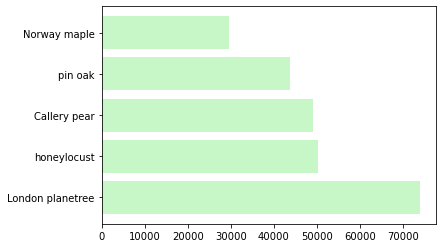

In [16]:
plt.barh(trees['spc_common'].value_counts().sort_values(ascending=False)[:5].index, trees['spc_common'].value_counts().sort_values(ascending=False)[:5], color='lightgreen', alpha=.5)

<BarContainer object of 5 artists>

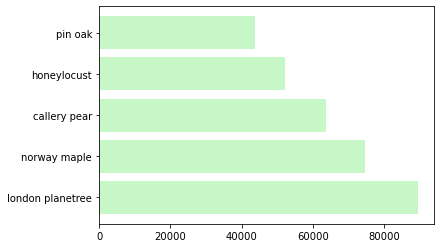

In [17]:
plt.barh(trees05['spc_common'].value_counts().sort_values(ascending=False)[:5].index, trees05['spc_common'].value_counts().sort_values(ascending=False)[:5], color='lightgreen', alpha=.5)


In [18]:
trees.groupby('spc_common')[['tree_diameter']].mean().sort_values('tree_diameter', ascending=False)

,tree_diameter
spc_common,
London planetree,21.888375
silver maple,21.109155
pin oak,17.233066
eastern cottonwood,16.463235
weeping willow,15.821705
...,...
false cypress,3.518868
Japanese snowbell,3.246334
pond cypress,3.170370


## Bring in shapefile of census tracts

In [19]:
ct.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."


In [20]:
ct.dtypes

boro_code       object
boro_ct201      object
boro_name       object
cdeligibil      object
ct2010          object
ctlabel         object
ntacode         object
ntaname         object
puma            object
shape_area     float64
shape_leng     float64
geometry      geometry
dtype: object

In [21]:
ct['ctlabel'].value_counts()

39        5
247       5
33        5
251       5
75        5
         ..
510.02    1
794       1
490       1
429       1
183.02    1
Name: ctlabel, Length: 1335, dtype: int64

In [22]:
# Create new label for census tracts to match other data we will bring in later
        
ct['boro_ctlabel'] = ct['boro_code'] + '_' + ct['ctlabel']

In [23]:
max([(len(x), x) for x in ct['boro_ctlabel']])

(9, '4_1579.03')

In [24]:
# Compare number of unique values for each label
ct['boro_ctlabel'].nunique(), ct['boro_ct201'].nunique(), ct['geometry'].nunique()

(2165, 2165, 2165)

In [25]:
ct.to_crs(epsg=2263, inplace=True)

<AxesSubplot:>

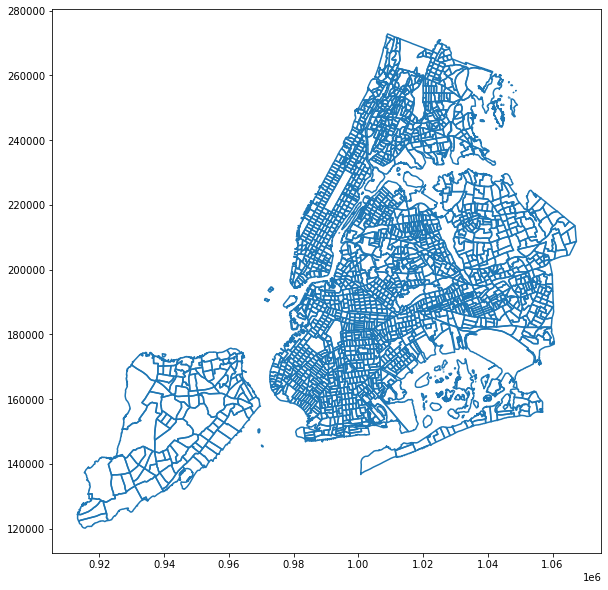

In [26]:
# Check plot
fig, ax = plt.subplots(figsize=(10,10))
ct.boundary.plot(ax=ax)

## Set up geometry for trees

In [27]:
# Some latitude and longitude for 2005 are not given. How many?
missing_latlong = trees05[(trees05['longitude'] == 0) | (trees05['latitude'] == 0)]
print(f"Pct missing lat/long: {missing_latlong.shape[0] / trees05.shape[0]}")

# Drop rows
trees05.drop(missing_latlong.index, inplace=True)

Pct missing lat/long: 0.014923055107263678


In [28]:
# Set up GeoDataFrame of trees
geometry = [Point(xy) for xy in zip(trees['longitude'], trees['latitude'])]
tree_gdf = gpd.GeoDataFrame(trees, geometry=geometry, crs="epsg:4326")

geometry_05 = [Point(xy) for xy in zip(trees05['longitude'], trees05['latitude'])]
trees05_gdf = gpd.GeoDataFrame(trees05, geometry=geometry_05, crs="epsg:4326")

# Match CRS
tree_gdf.to_crs(epsg=2263, inplace=True)
trees05_gdf.to_crs(epsg=2263, inplace=True)
tree_gdf.head()

,year,tree_diameter,Diameter_of_Stump_Measured,tree_status,tree_health_subjective,spc_latin,spc_common,sidw_damage,User_Type,Is_Root_Stone_Present,...,zip_code,borough,council_district,nta_name,census_tract_7dig,latitude,longitude,borough_name,alive,geometry
0,2015,3,0,Alive,Fair,Acer rubrum,red maple,0.0,TreesCount Staff,False,...,11375,4,29,Forest Hills,4073900,40.723092,-73.844215,Queens,1,POINT (1027431.148 202756.767)
1,2015,21,0,Alive,Fair,Quercus palustris,pin oak,1.0,TreesCount Staff,True,...,11357,4,19,Whitestone,4097300,40.794111,-73.818679,Queens,1,POINT (1034455.701 228644.838)
2,2015,3,0,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1.0,Volunteer,False,...,11211,3,34,East Williamsburg,3044900,40.717581,-73.936608,Brooklyn,1,POINT (1001822.833 200716.891)
3,2015,10,0,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1.0,Volunteer,True,...,11211,3,34,East Williamsburg,3044900,40.713537,-73.934456,Brooklyn,1,POINT (1002420.358 199244.251)
4,2015,21,0,Alive,Good,Tilia americana,American linden,1.0,Volunteer,True,...,11215,3,39,Park Slope-Gowanus,3016500,40.666778,-73.975979,Brooklyn,1,POINT (990913.776 182202.428)


In [29]:
trees05_gdf.head()

,year,est_address,tree_status_05,spc_latin,spc_common,sidw_damage,zip_code,borough,nta_name,latitude,longitude,alive,geometry
0,2005,1139 57 STREET,Good,Pyrus calleryana,callery pear,0,11219,3,Borough Park,40.632653,-74.000245,1,POINT (984182.000 169769.001)
1,2005,2220 BERGEN AVENUE,Good,Platanus acerifolia,london planetree,0,11234,3,Georgetown-Marine Park-Bergen Beach-Mill Basin,40.620084,-73.901453,1,POINT (1011607.999 165205.001)
2,2005,2360 BERGEN AVENUE,Good,Acer platanoides crimson king,norway-cr kng maple,0,11234,3,Georgetown-Marine Park-Bergen Beach-Mill Basin,40.617996,-73.899111,1,POINT (1012259.000 164444.999)
3,2005,2254 BERGEN AVENUE,Good,Platanus acerifolia,london planetree,0,11234,3,Georgetown-Marine Park-Bergen Beach-Mill Basin,40.619694,-73.901003,1,POINT (1011732.999 165063.000)
4,2005,2332 BERGEN AVENUE,Good,Platanus acerifolia,london planetree,0,11234,3,Georgetown-Marine Park-Bergen Beach-Mill Basin,40.618323,-73.899467,1,POINT (1012160.000 164563.998)


<AxesSubplot:>

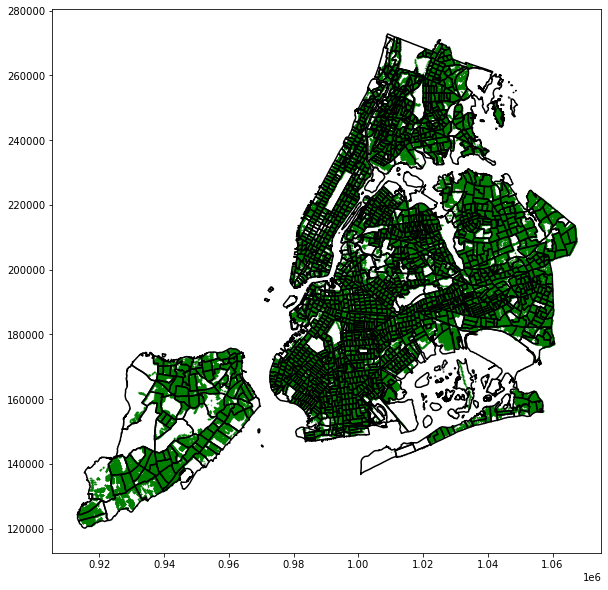

In [30]:
# Check plot - 2015
fig, ax = plt.subplots(figsize=(10,10))
ct.boundary.plot(ax=ax, color='black')
tree_gdf.plot(ax=ax, markersize=.25, color='green', alpha=.5)


<AxesSubplot:>

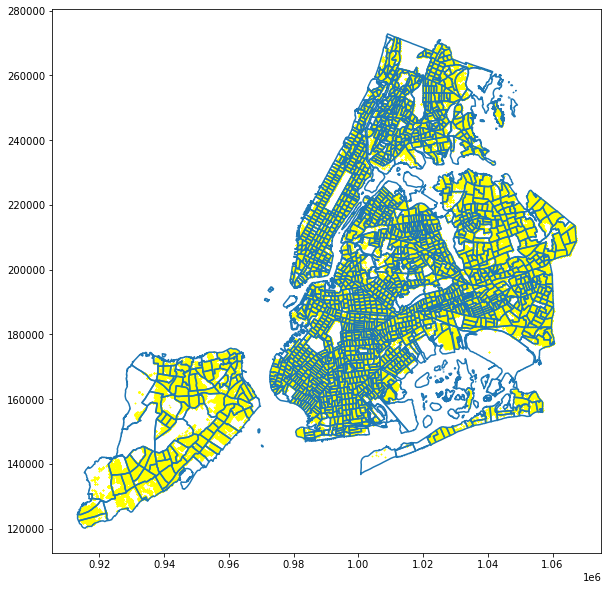

In [31]:
# Check plot - 2005
fig, ax = plt.subplots(figsize=(10,10))
trees05_gdf.plot(ax=ax, markersize=.25, color='yellow')
ct.boundary.plot(ax=ax)

## Use spatial joins to match trees to geographies

### 1. Census tracts

In [32]:
trees_ct = tree_gdf.sjoin(ct, how='left')
trees05_ct = trees05_gdf.sjoin(ct, how='left')
trees_ct.head()

,year,tree_diameter,Diameter_of_Stump_Measured,tree_status,tree_health_subjective,spc_latin,spc_common,sidw_damage,User_Type,Is_Root_Stone_Present,...,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,boro_ctlabel
0,2015,3,0,Alive,Fair,Acer rubrum,red maple,0.0,TreesCount Staff,False,...,Queens,I,073900,739,QN17,Forest Hills,4108,2.410956e+06,7295.047527,4_739
1,2015,21,0,Alive,Fair,Quercus palustris,pin oak,1.0,TreesCount Staff,True,...,Queens,I,097300,973,QN49,Whitestone,4103,5.577816e+06,11790.688043,4_973
2,2015,3,0,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1.0,Volunteer,False,...,Brooklyn,I,044900,449,BK90,East Williamsburg,4001,2.296259e+07,33958.122636,3_449
3,2015,10,0,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1.0,Volunteer,True,...,Brooklyn,I,044900,449,BK90,East Williamsburg,4001,2.296259e+07,33958.122636,3_449
4,2015,21,0,Alive,Good,Tilia americana,American linden,1.0,Volunteer,True,...,Brooklyn,I,016500,165,BK37,Park Slope-Gowanus,4005,2.010391e+06,6739.865006,3_165


In [33]:
trees05_ct.head()

,year,est_address,tree_status_05,spc_latin,spc_common,sidw_damage,zip_code,borough,nta_name,latitude,...,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,boro_ctlabel
0,2005,1139 57 STREET,Good,Pyrus calleryana,callery pear,0,11219,3,Borough Park,40.632653,...,Brooklyn,E,021600,216,BK88,Borough Park,4014,1.810244e+06,6210.278881,3_216
1,2005,2220 BERGEN AVENUE,Good,Platanus acerifolia,london planetree,0,11234,3,Georgetown-Marine Park-Bergen Beach-Mill Basin,40.620084,...,Brooklyn,I,070600,706,BK45,Georgetown-Marine Park-Bergen Beach-Mill Basin,4009,1.512576e+07,29508.069751,3_706
2,2005,2360 BERGEN AVENUE,Good,Acer platanoides crimson king,norway-cr kng maple,0,11234,3,Georgetown-Marine Park-Bergen Beach-Mill Basin,40.617996,...,Brooklyn,I,070600,706,BK45,Georgetown-Marine Park-Bergen Beach-Mill Basin,4009,1.512576e+07,29508.069751,3_706
3,2005,2254 BERGEN AVENUE,Good,Platanus acerifolia,london planetree,0,11234,3,Georgetown-Marine Park-Bergen Beach-Mill Basin,40.619694,...,Brooklyn,I,070600,706,BK45,Georgetown-Marine Park-Bergen Beach-Mill Basin,4009,1.512576e+07,29508.069751,3_706
4,2005,2332 BERGEN AVENUE,Good,Platanus acerifolia,london planetree,0,11234,3,Georgetown-Marine Park-Bergen Beach-Mill Basin,40.618323,...,Brooklyn,I,070600,706,BK45,Georgetown-Marine Park-Bergen Beach-Mill Basin,4009,1.512576e+07,29508.069751,3_706


In [34]:
# Drop and rename columns in 2015 dataframe
trees_ct.drop(columns=['index_right', 'census_tract_7dig', 'User_Type', 'council_district', 'nta_name', 'cdeligibil', 'boro_ct201', 'ntacode', 'ntaname', 'puma'], inplace=True)

# convert boolean to numeric
for col in trees_ct.columns:
    if trees_ct[col].dtype == 'bool':
        trees_ct[col] = trees_ct[col].astype(int)

# get dummies for subjective health category
trees_ct.rename(columns={'tree_health_subjective': 'health'}, inplace=True)
trees_ct = pd.get_dummies(trees_ct, columns=['health'], drop_first=False)

### 2. Community districts

In [35]:
cd.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [36]:
cd.head()

,BoroCD,Shape_Leng,Shape_Area,geometry
0,206,35875.711733,4.266431e+07,"POLYGON ((1019707.979 246708.141, 1019688.550 ..."
1,404,37018.373839,6.573966e+07,"POLYGON ((1026508.290 208553.862, 1026368.569 ..."
2,304,37007.806599,5.666261e+07,"POLYGON ((1012965.523 187886.949, 1012949.003 ..."
3,205,29443.048129,3.831698e+07,"POLYGON ((1014295.119 253236.989, 1014284.683 ..."
4,207,44812.147426,5.331169e+07,"POLYGON ((1018768.756 256840.862, 1018491.628 ..."


In [37]:
# New dataframe matching tree geometry points to community district polygons
# Only need this for 2015
trees_cd = tree_gdf.sjoin(cd, how='left')
trees_cd.head()

,year,tree_diameter,Diameter_of_Stump_Measured,tree_status,tree_health_subjective,spc_latin,spc_common,sidw_damage,User_Type,Is_Root_Stone_Present,...,census_tract_7dig,latitude,longitude,borough_name,alive,geometry,index_right,BoroCD,Shape_Leng,Shape_Area
0,2015,3,0,Alive,Fair,Acer rubrum,red maple,0.0,TreesCount Staff,False,...,4073900,40.723092,-73.844215,Queens,1,POINT (1027431.148 202756.767),57.0,406.0,42767.424344,8.270234e+07
1,2015,21,0,Alive,Fair,Quercus palustris,pin oak,1.0,TreesCount Staff,True,...,4097300,40.794111,-73.818679,Queens,1,POINT (1034455.701 228644.838),47.0,407.0,145327.606655,3.282886e+08
2,2015,3,0,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1.0,Volunteer,False,...,3044900,40.717581,-73.936608,Brooklyn,1,POINT (1001822.833 200716.891),46.0,301.0,68935.801518,1.317033e+08
3,2015,10,0,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1.0,Volunteer,True,...,3044900,40.713537,-73.934456,Brooklyn,1,POINT (1002420.358 199244.251),46.0,301.0,68935.801518,1.317033e+08
4,2015,21,0,Alive,Good,Tilia americana,American linden,1.0,Volunteer,True,...,3016500,40.666778,-73.975979,Brooklyn,1,POINT (990913.776 182202.428),62.0,306.0,82155.681306,8.550156e+07


In [38]:
# Add column to census tract dataframe (main dataframe) based on community district matches
trees_ct['BoroCD'] = trees_cd['BoroCD']

### Check work

In [39]:
trees05_ct.isnull().sum()

year               0
est_address        0
tree_status_05     0
spc_latin          0
spc_common         0
sidw_damage        0
zip_code           0
borough            0
nta_name           0
latitude           0
longitude          0
alive              0
geometry           0
index_right       83
boro_code         83
boro_ct201        83
boro_name         83
cdeligibil        83
ct2010            83
ctlabel           83
ntacode           83
ntaname           83
puma              83
shape_area        83
shape_leng        83
boro_ctlabel      83
dtype: int64

In [40]:
trees05_ct.shape, trees_ct.shape

((575453, 26), (567858, 36))

In [41]:
# drop missing values and save
trees_ct.dropna(inplace=True)
trees05_ct.dropna(inplace=True)

trees_ct.to_file('../gitignore/pre-aggregate_df_15.shp')
trees05_ct.to_file('../gitignore/pre-aggregate_df_05.shp')

/var/folders/by/f27ws03s62v8tb7315j3kxm80000gn/T/ipykernel_1901/2402817977.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  trees_ct.to_file('../gitignore/pre-aggregate_df_15.shp')


KeyboardInterrupt: 

In [27]:
trees05_ct.dtypes

year                 int64
est_address         object
tree_status_05      object
spc_latin           object
spc_common          object
sidw_damage          int64
zip_code             int64
borough              int64
nta_name            object
latitude           float64
longitude          float64
alive                int64
geometry          geometry
index_right        float64
boro_code           object
boro_ct201          object
boro_name           object
cdeligibil          object
ct2010              object
ctlabel             object
ntacode             object
ntaname             object
puma                object
shape_area         float64
shape_leng         float64
boro_ctlabel        object
dtype: object

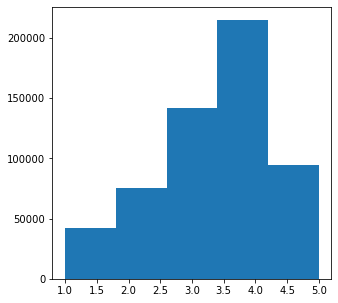

In [28]:
plt.figure(figsize=(5,5))
plt.hist(trees_ct['borough'], bins=5);

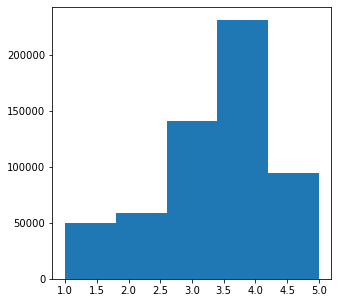

In [265]:
plt.figure(figsize=(5,5))
plt.hist(trees05_ct['boro_code'].astype(int), bins=5);

# Aggregates by census tract

In [42]:
#trees_ct = gpd.read_file('../gitignore/pre-aggregate_df_15.shp')
#trees05_ct = gpd.read_file('../gitignore/pre-aggregate_df_05.shp')

### 2015

In [47]:
# Create DF with summary stats for each ct, including main (mean) community district categorization
tree_stats = trees_ct.groupby('boro_ctlabel')[['borough', 'shape_area', 'tree_diameter', 'alive', 'health_Good', 'health_Fair', 'health_Poor', 'health_None']].mean()

# Rename columns
tree_stats.rename(columns={'tree_diameter': 'mean_tree_diam', 
                           'shape_area': 'tract_area'}, inplace=True)

# Add more columns
tree_stats['tree_count'] = trees_ct.groupby('boro_ctlabel')['spc_common'].count().values
tree_stats['tree_density'] = tree_stats['tree_count'] / tree_stats['tract_area'] * 10**6
tree_stats['n_species'] = trees_ct.groupby('boro_ctlabel')['spc_latin'].nunique().values
tree_stats['BoroCD'] = trees_ct.groupby('boro_ctlabel')[['BoroCD']].agg(pd.Series.mode)

# Convert floats to integers
tree_stats['borough'] = tree_stats['borough'].astype(int)
tree_stats['BoroCD'] = tree_stats['BoroCD'].map(lambda x: round(x))

In [48]:
tree_stats.head()

,borough,tract_area,mean_tree_diam,alive,health_Good,health_Fair,health_Poor,health_None,tree_count,tree_density,n_species,BoroCD
boro_ctlabel,,,,,,,,,,,,
1_10.01,1,8.678058e+05,9.416667,0.833333,0.333333,0.250000,0.250000,0.166667,12,13.827978,5,103
1_10.02,1,2.225720e+06,8.037037,1.000000,0.555556,0.222222,0.222222,0.000000,27,12.130905,14,103
1_100,1,1.859881e+06,7.268116,0.992754,0.572464,0.326087,0.094203,0.007246,138,74.198295,17,105
1_101,1,1.891378e+06,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1,0.528715,1,105
1_102,1,1.860993e+06,5.880000,1.000000,0.640000,0.360000,0.000000,0.000000,25,13.433691,3,105


### 2005

In [49]:
# Create DF with summary stats for each census tract
tree_stats_05 = trees05_ct.groupby('boro_ctlabel')[['shape_area','alive']].mean()

# Set numeric CD as index
tree_stats_05.reset_index(inplace=True)
tree_stats_05.set_index('boro_ctlabel', inplace=True)

# Rename columns
tree_stats_05.rename(columns={'alive': 'alive_05', 
                              'shape_area': 'tract_area'}, inplace=True)

# Add more columns
tree_stats_05['tree_count_05'] = trees05_ct.groupby('boro_ctlabel')['spc_common'].count().values
tree_stats_05['tree_density_05'] = tree_stats_05['tree_count_05'] / tree_stats_05['tract_area'] * 10**6
tree_stats_05['n_species_05'] = trees05_ct.groupby('boro_ctlabel')['spc_latin'].nunique().values

In [50]:
tree_stats_05.head()

,tract_area,alive_05,tree_count_05,tree_density_05,n_species_05
boro_ctlabel,,,,,
1_10.01,8.678058e+05,1.000000,7,8.066321,2
1_10.02,2.225720e+06,0.884615,26,11.681612,7
1_100,1.859881e+06,1.000000,137,73.660626,12
1_101,1.891378e+06,1.000000,21,11.103018,5
1_102,1.860993e+06,1.000000,131,70.392539,12


In [51]:
tree_stats_05.shape, tree_stats.shape

((2142, 5), (2148, 12))

### Combine summary stats into single df

In [52]:
# Add 2005 aggregates to 2015 dataframe
tree_stats = pd.merge(tree_stats, tree_stats_05.drop(columns=['tract_area']), how='left', on='boro_ctlabel')

In [53]:
# Add change columns
tree_stats['treecount_chg'] = (tree_stats['tree_count'] - tree_stats['tree_count_05']) / tree_stats['tree_count_05']
tree_stats['treedens_chg'] = (tree_stats['tree_density'] - tree_stats['tree_density_05']) / tree_stats['tree_density_05']
tree_stats['nspecies_chg'] = (tree_stats['n_species'] - tree_stats['n_species_05']) / tree_stats['n_species_05']
tree_stats['alive_chg'] = (tree_stats['alive'] - tree_stats['alive_05']) / tree_stats['alive_05']

### Add community district labels to 2015 aggregate dataframe

In [56]:
# Add labels for community districts
# Dictionary from community_districts notebook
cd_dict = {503: 'Tottenville and Great Kills (CD3)',
     502: 'South Beach and Willowbrook (CD2)',
     501: 'St. George and Stapleton (CD1)',
     414: 'Rockaway and Broad Channel (CD14)',
     413: 'Queens Village (CD13)',
     412: 'Jamaica and Hollis (CD12)',
     411: 'Bayside and Little Neck (CD11)',
     410: 'South Ozone Park and Howard Beach (CD10)',
     409: 'Kew Gardens and Woodhaven (CD9)',
     408: 'Hillcrest and Fresh Meadows (CD8)',
     407: 'Flushing and Whitestone (CD7)',
     406: 'Rego Park and Forest Hills (CD6)',
     405: 'Ridgewood and Maspeth (CD5)',
     404: 'Elmhurst and Corona (CD4)',
     403: 'Jackson Heights (CD3)',
     402: 'Woodside and Sunnyside (CD2)',
     401: 'Long Island City and Astoria (CD1)',
     318: 'Flatlands and Canarsie (CD18)',
     317: 'East Flatbush (CD17)',
     316: 'Brownsville (CD16)',
     315: 'Sheepshead Bay (CD15)',
     314: 'Flatbush and Midwood (CD14)',
     313: 'Coney Island (CD13)',
     312: 'Borough Park (CD12)',
     311: 'Bensonhurst (CD11)',
     310: 'Bay Ridge and Dyker Heights (CD10)',
     309: 'South Crown Heights and Lefferts Gardens (CD9)',
     308: 'Crown Heights and Prospect Heights (CD8)',
     307: 'Sunset Park (CD7)',
     306: 'Park Slope and Carroll Gardens (CD6)',
     305: 'East New York and Starrett City (CD5)',
     304: 'Bushwick (CD4)',
     303: 'Bedford Stuyvesant (CD3)',
     302: 'Fort Greene and Brooklyn Heights (CD2)',
     301: 'Greenpoint and Williamsburg (CD1)',
     212: 'Williamsbridge and Baychester (CD12)',
     211: 'Morris Park and Bronxdale (CD11)',
     210: 'Throgs Neck and Co-op City (CD10)',
     209: 'Parkchester and Soundview (CD9)',
     208: 'Riverdale and Fieldston (CD8)',
     207: 'Kingsbridge Heights and Bedford (CD7)',
     206: 'Belmont and East Tremont (CD6)',
     205: 'Fordham and University Heights (CD5)',
     204: 'Highbridge and Concourse (CD4)',
     203: 'Morrisania and Crotona (CD3)',
     202: 'Hunts Point and Longwood (CD2)',
     201: 'Mott Haven and Melrose (CD1)',
     112: 'Washington Heights and Inwood (CD12)',
     111: 'East Harlem (CD11)',
     110: 'Central Harlem (CD10)',
     109: 'Morningside Heights and Hamilton Heights (CD9)',
     108: 'Upper East Side (CD8)',
     107: 'Upper West Side (CD7)',
     106: 'Stuyvesant Town and Turtle Bay (CD6)',
     105: 'Midtown (CD5)',
     104: 'Clinton and Chelsea (CD4)',
     103: 'Lower East Side and Chinatown (CD3)',
     102: 'Greenwich Village and Soho (CD2)',
     101: 'Financial District (CD1)',
          164:'Central Park', 
          226: 'Van Cortlandt Park', 
          227: 'Bronx Park', 
          228: 'Pelham Bay Park', 
          355: 'Prospect Park', 
          356: 'Gateway National Park (BK)', 
          480: 'LaGuardia Airport', 
          481: 'Flushing Meadows Park', 
          482: 'Forest Park', 
          483: 'JFK Airport', 
          484: 'Gateway National Park (QN)', 
          595: 'Gateway National Park (SI)'}

tree_stats['CD_name'] = tree_stats['BoroCD'].map(cd_dict)

In [57]:
# Any nulls?
tree_stats.isna().sum()

borough             0
tract_area          0
mean_tree_diam      0
alive               0
health_Good         0
health_Fair         0
health_Poor         0
health_None         0
tree_count          0
tree_density        0
n_species           0
BoroCD              0
alive_05           13
tree_count_05      13
tree_density_05    13
n_species_05       13
treecount_chg      13
treedens_chg       13
nspecies_chg       13
alive_chg          13
CD_name             0
dtype: int64

In [58]:
# Which ones didn't match?
tree_stats[tree_stats['CD_name'].isna()]['BoroCD'].unique()

array([], dtype=int64)

In [59]:
# These are the community districts we have air quality data - from air_quality_setup notebook:
airqual_cds = [503, 502, 501, 414, 413, 412, 411, 410, 409, 408, 407, 406, 405,
       404, 403, 402, 401, 318, 317, 316, 315, 314, 313, 312, 311, 310,
       309, 308, 307, 306, 305, 304, 303, 302, 301, 212, 211, 210, 209,
       208, 207, 206, 205, 204, 203, 202, 201, 112, 111, 110, 109, 108,
       107, 106, 105, 104, 103, 102, 101]

print([x for x in tree_stats[tree_stats['CD_name'].isna()]['BoroCD'].unique() if x not in airqual_cds])
print([x for x in tree_stats[tree_stats['CD_name'].isna()]['BoroCD'].unique() if x in airqual_cds])

# So we will leave these unmatched, as we don't have air qual data.

[]
[]


In [43]:
tree_stats['tree_count'].describe()

count    2148.000000
mean      264.335661
std       292.166495
min         1.000000
25%       126.000000
50%       194.000000
75%       288.000000
max      3771.000000
Name: tree_count, dtype: float64

<AxesSubplot:xlabel='tree_count'>

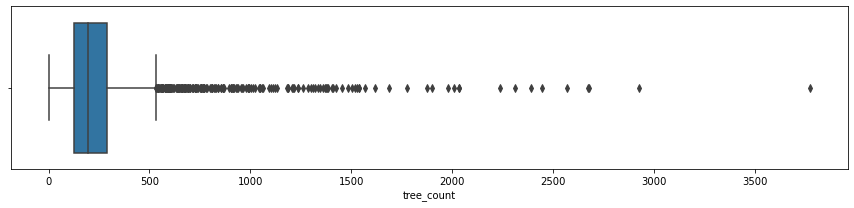

In [44]:
# Consider whether to drop rows with very few trees
plt.figure(figsize=(15, 3))
sns.boxplot(x=tree_stats['tree_count'])

In [45]:
len(tree_stats[tree_stats['tree_count'] < 30])

77

- Since census tracts are quite small geographically and many have few trees, we will not drop any. 

In [305]:
tree_stats.shape[0], ct.shape[0]

(2148, 2165)

In [60]:
# Combine this df with census tract geometry df in order to map w/ summary stats

ct_stats = pd.merge(tree_stats, ct[['boro_ctlabel', 'geometry']], how='left', on='boro_ctlabel', copy=False)
ct_stats.set_index('boro_ctlabel', inplace=True)
ct_stats.head()

,borough,tract_area,mean_tree_diam,alive,health_Good,health_Fair,health_Poor,health_None,tree_count,tree_density,...,alive_05,tree_count_05,tree_density_05,n_species_05,treecount_chg,treedens_chg,nspecies_chg,alive_chg,CD_name,geometry
boro_ctlabel,,,,,,,,,,,,,,,,,,,,,
1_10.01,1,8.678058e+05,9.416667,0.833333,0.333333,0.250000,0.250000,0.166667,12,13.827978,...,1.000000,7.0,8.066321,2.0,0.714286,0.714286,1.500000,-0.166667,Lower East Side and Chinatown (CD3),"POLYGON ((991128.254 199590.251, 991121.229 19..."
1_10.02,1,2.225720e+06,8.037037,1.000000,0.555556,0.222222,0.222222,0.000000,27,12.130905,...,0.884615,26.0,11.681612,7.0,0.038462,0.038462,1.000000,0.130435,Lower East Side and Chinatown (CD3),"POLYGON ((991592.144 201146.692, 991543.601 20..."
1_100,1,1.859881e+06,7.268116,0.992754,0.572464,0.326087,0.094203,0.007246,138,74.198295,...,1.000000,137.0,73.660626,12.0,0.007299,0.007299,0.416667,-0.007246,Midtown (CD5),"POLYGON ((993101.222 216017.046, 992982.220 21..."
1_101,1,1.891378e+06,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1,0.528715,...,1.000000,21.0,11.103018,5.0,-0.952381,-0.952381,-0.800000,0.000000,Midtown (CD5),"POLYGON ((987638.873 212444.531, 987582.221 21..."
1_102,1,1.860993e+06,5.880000,1.000000,0.640000,0.360000,0.000000,0.000000,25,13.433691,...,1.000000,131.0,70.392539,12.0,-0.809160,-0.809160,-0.750000,0.000000,Midtown (CD5),"POLYGON ((992216.539 216507.687, 992091.031 21..."


In [72]:
tree_stats.columns

Index(['borough', 'tract_area', 'mean_tree_diam', 'alive', 'health_Good',
       'health_Fair', 'health_Poor', 'health_None', 'BoroCD', 'tree_count',
       'tree_density', 'n_species', 'alive_05', 'tree_count_05',
       'tree_density_05', 'n_species_05', 'treecount_chg', 'treedens_chg',
       'nspecies_chg', 'alive_chg', 'CD_name'],
      dtype='object')

In [307]:
ct_stats.shape

(2148, 22)

In [308]:
ct_stats.dtypes

borough               int64
tract_area          float64
mean_tree_diam      float64
alive               float64
health_Good         float64
health_Fair         float64
health_Poor         float64
health_None         float64
BoroCD                int64
tree_count            int64
tree_density        float64
n_species             int64
alive_05            float64
tree_count_05       float64
tree_density_05     float64
n_species_05        float64
treecount_chg       float64
treedens_chg        float64
nspecies_chg        float64
alive_chg           float64
CD_name              object
geometry           geometry
dtype: object

In [61]:
ct_stats.to_file('../gitignore/treestats_pre_airqual.shp')

/var/folders/by/f27ws03s62v8tb7315j3kxm80000gn/T/ipykernel_1901/3659936328.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ct_stats.to_file('../gitignore/treestats_pre_airqual.shp')


# Add data by community district

In [4]:
#ct_stats = gpd.read_file('../gitignore/treestats_pre_airqual.csv')

### 1. Air quality

In [63]:
air = pd.read_csv('../data/air_quality/nyc_airqual_by_cd.csv')
air.rename(columns={'Unnamed: 0': 'CD'}, inplace=True)
air.set_index('CD', inplace=True)
air.head()

,2013 Summer_FPM,2016-17 Winter_FPM,2009-10 Winter_FPM,2012-13 Winter_FPM,2009 Summer_FPM,2010 Summer_FPM,2010-11 Winter_FPM,2015 Summer_FPM,2014-15 Winter_FPM,2015-16 Winter_FPM,...,Summ_NO2_09-17Chg,Wint_NO2_09-17Chg,SO2_09-16Chg,O3_09-17Chg,Summ_FPM_12-17Chg,Wint_FPM_12-17Chg,Summ_NO2_12-17Chg,Wint_NO2_12-17Chg,SO2_12-16Chg,O3_12-17Chg
CD,,,,,,,,,,,,,,,,,,,,,
503,9.13,6.87,9.07,9.60,10.39,11.27,11.52,8.44,8.06,7.17,...,-0.282146,-0.093880,-0.938889,0.042707,-0.192857,-0.284375,-0.033624,0.046108,-0.717949,-0.182927
502,9.41,7.17,9.02,9.76,10.56,11.51,11.65,8.77,8.51,7.49,...,-0.283165,-0.140924,-0.944954,0.064839,-0.180542,-0.265369,-0.139665,-0.038140,-0.727273,-0.147181
501,9.47,7.23,9.15,9.85,10.58,11.57,11.97,8.91,8.72,7.87,...,-0.285960,-0.175944,-0.949219,0.105750,-0.155311,-0.265990,-0.147743,-0.078764,-0.740000,-0.127538
414,9.44,7.29,7.94,9.23,9.60,10.74,10.28,8.28,7.39,5.92,...,-0.090047,0.002393,-0.915966,0.047789,-0.178533,-0.210184,-0.053021,0.115610,-0.607843,-0.126238
413,9.77,7.72,8.86,9.29,9.67,10.99,11.43,8.76,8.23,6.90,...,-0.210986,-0.071676,-0.917197,0.147748,-0.131880,-0.168999,-0.119164,0.169985,-0.566667,-0.088698


In [64]:
air.isnull().sum().sum()

0

In [65]:
air.shape

(59, 75)

In [66]:
sorted(air.columns)

['2005_TrafficDens_Car',
 '2005_TrafficDens_Truck',
 '2005_TrafficDens_Vehicle',
 '2008-09 Winter_FPM',
 '2008-09 Winter_NO2',
 '2008-09 Winter_SO2',
 '2009 Summer_FPM',
 '2009 Summer_NO2',
 '2009 Summer_O3',
 '2009-10 Winter_FPM',
 '2009-10 Winter_NO2',
 '2009-10 Winter_SO2',
 '2010 Summer_FPM',
 '2010 Summer_NO2',
 '2010 Summer_O3',
 '2010-11 Winter_FPM',
 '2010-11 Winter_NO2',
 '2010-11 Winter_SO2',
 '2011 Summer_FPM',
 '2011 Summer_NO2',
 '2011 Summer_O3',
 '2011-12 Winter_FPM',
 '2011-12 Winter_NO2',
 '2011-12 Winter_SO2',
 '2012 Summer_FPM',
 '2012 Summer_NO2',
 '2012 Summer_O3',
 '2012-13 Winter_FPM',
 '2012-13 Winter_NO2',
 '2012-13 Winter_SO2',
 '2013 Summer_FPM',
 '2013 Summer_NO2',
 '2013 Summer_O3',
 '2013-14 Winter_FPM',
 '2013-14 Winter_NO2',
 '2013-14 Winter_SO2',
 '2014 Summer_FPM',
 '2014 Summer_NO2',
 '2014 Summer_O3',
 '2014-15 Winter_FPM',
 '2014-15 Winter_NO2',
 '2014-15 Winter_SO2',
 '2015 Summer_FPM',
 '2015 Summer_NO2',
 '2015 Summer_O3',
 '2015-16 Winter_FPM',


In [67]:
# Add air quality measures to tree_stats based on main community district overlap
for measure in air.columns:
    measure_dict = {}
    for cd in air.index:
        measure_dict[cd] = air.loc[cd, measure]
    ct_stats[measure] = ct_stats['BoroCD'].map(measure_dict)


In [68]:
ct_stats.head()

,borough,tract_area,mean_tree_diam,alive,health_Good,health_Fair,health_Poor,health_None,tree_count,tree_density,...,Summ_NO2_09-17Chg,Wint_NO2_09-17Chg,SO2_09-16Chg,O3_09-17Chg,Summ_FPM_12-17Chg,Wint_FPM_12-17Chg,Summ_NO2_12-17Chg,Wint_NO2_12-17Chg,SO2_12-16Chg,O3_12-17Chg
boro_ctlabel,,,,,,,,,,,,,,,,,,,,,
1_10.01,1,8.678058e+05,9.416667,0.833333,0.333333,0.250000,0.250000,0.166667,12,13.827978,...,-0.298023,-0.228850,-0.958631,0.200093,-0.109251,-0.262295,-0.180544,-0.068762,-0.840659,-0.100659
1_10.02,1,2.225720e+06,8.037037,1.000000,0.555556,0.222222,0.222222,0.000000,27,12.130905,...,-0.298023,-0.228850,-0.958631,0.200093,-0.109251,-0.262295,-0.180544,-0.068762,-0.840659,-0.100659
1_100,1,1.859881e+06,7.268116,0.992754,0.572464,0.326087,0.094203,0.007246,138,74.198295,...,-0.315111,-0.281843,-0.958212,0.482615,-0.193243,-0.313238,-0.235994,-0.072542,-0.863924,-0.053706
1_101,1,1.891378e+06,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1,0.528715,...,-0.315111,-0.281843,-0.958212,0.482615,-0.193243,-0.313238,-0.235994,-0.072542,-0.863924,-0.053706
1_102,1,1.860993e+06,5.880000,1.000000,0.640000,0.360000,0.000000,0.000000,25,13.433691,...,-0.315111,-0.281843,-0.958212,0.482615,-0.193243,-0.313238,-0.235994,-0.072542,-0.863924,-0.053706


In [69]:
ct_stats.isnull().sum()
# Will deal with these later, in modeling

borough               0
tract_area            0
mean_tree_diam        0
alive                 0
health_Good           0
                     ..
Wint_FPM_12-17Chg    13
Summ_NO2_12-17Chg    13
Wint_NO2_12-17Chg    13
SO2_12-16Chg         13
O3_12-17Chg          13
Length: 97, dtype: int64

In [70]:
# Shorten column names to reduce issues with truncating
def rename_cols(col):
    return col.replace('Summer', 'S').replace('Winter', 'W').replace(' ', '').replace('20', '').replace('TrafficDens', 'TD')


ct_stats.rename(columns=rename_cols, inplace=True)

### Save

In [71]:
ct_stats.to_csv('../data/tree_census/tree_air_summary_ct.csv')
ct_stats.to_file('../data/tree_census/tree_air_summary_ct.shp')

/var/folders/by/f27ws03s62v8tb7315j3kxm80000gn/T/ipykernel_1901/842747815.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ct_stats.to_file('../data/tree_census/tree_air_summary_ct.shp')
